# Part 1: Length Contraction

First we're going to get our favorite image, Microsoft Bob

(597, 307)
{'srgb': 0, 'gamma': 0.45455, 'transparency': 255, 'dpi': (95.9866, 95.9866), 'Software': 'Paint.NET v3.5.10'}


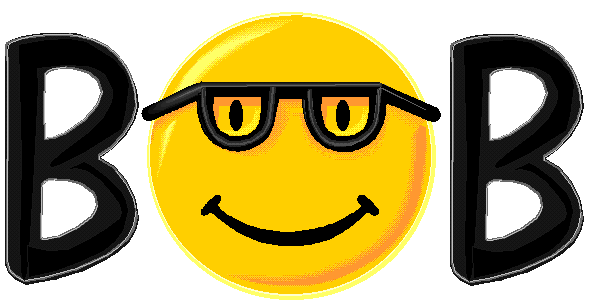

In [1]:
from PIL import Image

bob = Image.open('Microsoft_Bob_Logo.png')
print(bob.size)
print(bob.info)
bob

Next we convert our image into an array

In [2]:
import numpy as np

bob = bob.convert("RGBA") #have to do this so our array is nice
arr = np.array(bob)
print(arr.shape)
IMAGE_HEIGHT, IMAGE_WIDTH, _ = arr.shape

(307, 597, 4)


Next we turn each pixel in our array into a 2d vector and corresponding color, filtering out transparent pixels

In [3]:
def pilndarraytomatrix(pilarr: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Converts a 3d RGBA array to two parallel arrays of 2d location vectors and colors
    :param pilarr: 3d RGBA array
    :return: tuple of vectors and colors, in that order
    """
    cols = []
    colorslist = []
    for y, row in enumerate(pilarr):
        for x, pixel in enumerate(row):
            if pixel[3] == 255: #if alpha channel is 255(completely opaque), add to lists
                cols.append(np.array([x,y],dtype='float32'))
                colorslist.append(np.array(pixel))
    return np.array(cols, dtype='float32'), np.array(colorslist, dtype='float32')

matrix, colors = pilndarraytomatrix(arr)
print(matrix.shape)
print(colors.shape)

(113241, 2)
(113241, 4)


Now we need to account for length contraction as predicted by SR. In this notebook we're only going to contract in the x-direction, but if you wanted to you could contract in any direction just by applying a rotation matrix to the image vectors before and after the transforms are made.

In [4]:
FRAC_SPEED_OF_LIGHT = .8

In [5]:
import numbers
import math

def length_contract(vfrac: numbers.Real, matrixtocontract: np.ndarray) -> None:
    """
    Contracts a matrix of columns vectors along the i-hat/x-hat direction
    :param vfrac: Fraction of the speed of light the object is travelling at
    :param matrixtocontract: matrix to contract
    :return: None, in-place
    """
    lorentz_factor = math.sqrt(1 - vfrac**2)
    matrixtocontract[0] *= lorentz_factor

length_contract(FRAC_SPEED_OF_LIGHT, np.transpose(matrix))
matrix

array([[168.     ,  12.     ],
       [168.6    ,  12.     ],
       [169.20001,  12.     ],
       ...,
       [180.6    , 299.     ],
       [181.20001, 299.     ],
       [181.8    , 299.     ]], dtype=float32)

Now we can convert our arrays back to an image after contraction.

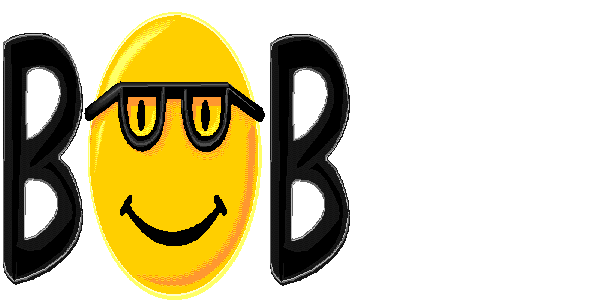

In [6]:
def matrixandcolorstopil(matrixtoconv: np.ndarray, colorstoconv: np.ndarray, shape:tuple[numbers.Integral,numbers.Integral, numbers.Integral]) -> Image:
    """
    Converts two parallel arrays of 2d location vectors and colors into an image of the givem shape
    :param matrixtoconv: numpy array of row vectors to convert
    :param colorstoconv: parallel array of RGBA colors
    :param shape: output shape
    :return: Image generated from vectors & colors
    """
    imagearr = np.zeros(shape, dtype='uint8')
    for vec, color in zip(matrixtoconv,colorstoconv):
        imagearr[math.floor(vec[1])][math.floor(vec[0])] = color
    return Image.fromarray(imagearr)

matrixandcolorstopil(matrix, colors, arr.shape)

# Part 2: Speed of Light Delay

Next we need to take into account the speed of light delay when observing from a point(as human eyes and cameras do)
Towards the edges of the object, if the direction of travel is to the right, they get distorted to the left.
This is because our cameras capture light at a specific moment. Looking at the middle of the object, things are fine, but towards the edges,
the distance between the observation point and the pixel gets longer. Therefore, to account for that longer distance we must look backwards in time
to find when that pixel emitted and reached our eyes at the moment.

The following equation describes the displacement backwards in time needed to account for this effect when solved for t:

$\frac{\sqrt{\left(x-vt-\frac{w}{2}\right)^2+\left(y-\frac{h}{2}\right)+d^2}}{c}-t=\frac{d}{c}$

To get the backwards x-displacement we can use:

${\Delta}x=-vt$

The following code solves this equation, plugs it into the formula for displacement, and converts it into an efficient numpy function

In [7]:
import sympy as sym
def getcalc():
    """
    :return: a function that calculates speed-of-light delay(sympy is awesome!)
    """
    x, y, v, w, h, d, c, t = sym.symbols('x y v w h d c t')
    expr = sym.solve(sym.Eq(
        (sym.sqrt((x-(v*t)-w/2)**2 + (y-(h/2))**2 + d**2)/c) - t
        ,
        d/c
    ), t)[0]
    x_disp = expr * -1 * v
    return sym.lambdify([x,y,v,w,h,d,c],x_disp, 'numpy')

We then convert this displacement factor into a function we can use

In [8]:
displacement = getcalc()

def get_transform(v, w, h, d, c):
    """
    Gets 0-arg transform for use in apply_along_axis
    :param v: velocity of object
    :param w: width of object
    :param h: height of object
    :param d: distance to object
    :param c: speed of light
    :return: function that can transform a 2d row vector along the x-dir to account for speed-of-light delay
    """
    def transformvec(vec: np.ndarray) -> np.ndarray:
        x, y = vec
        x_prime = x + displacement(x,y,v,w,h,d,c)
        return np.array([x_prime, y], dtype='float32')
    return transformvec

We can now apply this transformation to the matrix. Our vectors are currently unscaled, so we can either scale them or use their unit vector as the basis for units in this system
Here, we define 1 pixel = 1mm

In [9]:
SPEED_OF_LIGHT = 3 * (10**11) # in mm/s
DISTANCE_FROM_OBJECT = 250 # (25cm)

transformed_matrix = np.apply_along_axis(get_transform(FRAC_SPEED_OF_LIGHT * SPEED_OF_LIGHT, IMAGE_WIDTH, IMAGE_HEIGHT, DISTANCE_FROM_OBJECT,SPEED_OF_LIGHT), 1, matrix)
print(f'Before:\n{matrix}')
print(f'After:\n{transformed_matrix}')

Before:
[[168.       12.     ]
 [168.6      12.     ]
 [169.20001  12.     ]
 ...
 [180.6     299.     ]
 [181.20001 299.     ]
 [181.8     299.     ]]
After:
[[ 78.56729   12.      ]
 [ 79.7335    12.      ]
 [ 80.89601   12.      ]
 ...
 [ 99.902214 299.      ]
 [100.99703  299.      ]
 [102.08843  299.      ]]


We now need to transform our vectors to be centered in the image

In [10]:
WIDTH_EXTENSION_FACTOR = 2
mean_x = np.mean(transformed_matrix[:,0])
transformed_matrix[:,0] -= mean_x
transformed_matrix[:,0] += (IMAGE_WIDTH * WIDTH_EXTENSION_FACTOR / 2)

We would now like to convert this to an image.

(113241, 2)
(113241,)


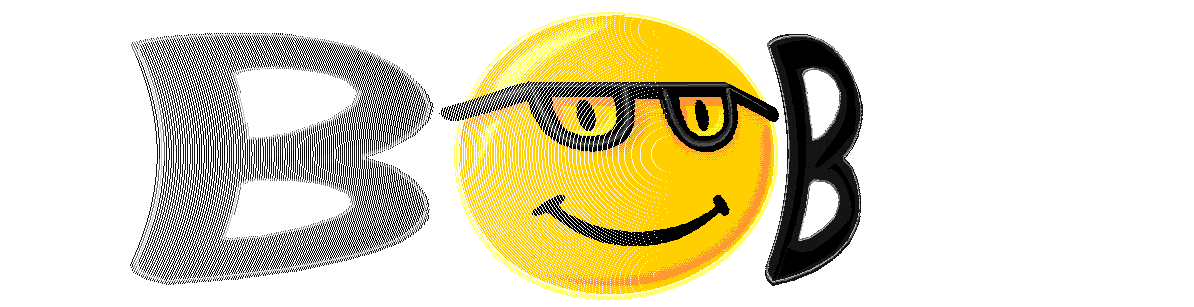

In [11]:
def getboundschecker(height, width):
    """
    Checks 2d row vector to make sure it's in the bounds of the image
    :param height: image height
    :param width: image width
    :return: True if vector is in image bounds, False otherwise
    """
    def checkbounds(tobechecked: np.ndarray):
        return (tobechecked >= 0).all() and (tobechecked < np.array([width,height])).all()
    return checkbounds

validvecs = np.apply_along_axis(getboundschecker(IMAGE_HEIGHT, IMAGE_WIDTH * WIDTH_EXTENSION_FACTOR), 1, transformed_matrix)
print(transformed_matrix.shape)
print(validvecs.shape)
final_matrix = transformed_matrix[validvecs]
final_colors = colors[validvecs]

image = matrixandcolorstopil(final_matrix,final_colors,(IMAGE_HEIGHT,IMAGE_WIDTH * 2,4))
image